In [1]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

### Initialise the environment

In [2]:
p1 = 0.80 # true expected payoff for arm 1
p2 = 0.40 # true expected payoff for arm 2

arms = [p1, p2]

### Initialise the agent

In [3]:
def policy(q_values, temp=None, type='softmax'):

    if temp:
        t = temp
    else:
        t = 1
    if type == 'softmax':
        return np.exp(q_values*t)/np.sum(np.exp(q_values*t))
    else:
        return np.array(q_values >= q_values.max()).astype(int)

def belief_update(M_curr, arm, rew):

    M_next = M_curr.copy()
    if rew == 1:
        M_next[arm, 0] += 1
    else:
        M_next[arm, 1] += 1
    return M_next

gamma   = 0.9
gittins = np.genfromtxt('../Data/Gittins/gittins200_gamma09.csv', delimiter=',') # load gittins indices
gittins = gittins[1:, 1:] # remove (0, .) and (., 0) priors

# initial belief state
M = np.array([
    [1, 1],
    [1, 1]
], dtype=int)

temp = 1 # inverse temperature for softmax

### Run the model-free agent

In [4]:
np.random.seed(1234)

num_episodes = 180
for ep in range(num_episodes):
    Q  = np.array([gittins[M[0, 0], M[0, 1]], gittins[M[1, 0], M[1, 1]]])
    # a = np.argmax(Q)
    ps = policy(Q, temp=temp)
    a  = np.random.choice([0, 1], p=ps)
    r  = np.random.choice([0, 1], p=(1-arms[a], arms[a]))
    M  = belief_update(M, a, r)

### Plot the resulting belief

Text(0.5, 1.0, '$\\mathbb{E}[p\\mid b]$')

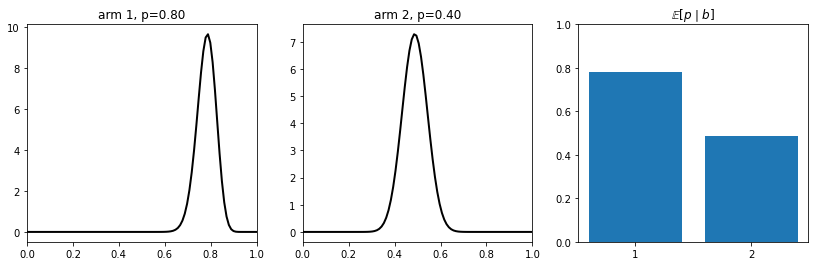

In [5]:
plt.figure(figsize=(14, 4))

x = np.linspace(0, 1, 100)
plt.subplot(1, 3, 1)
a, b = M[0, 0], M[0, 1]
rv = beta(a, b)
plt.plot(x, rv.pdf(x), 'k-', lw=2)
plt.xlim(0,1)
plt.title('arm 1, p=%.2f'%arms[0])
plt.subplot(1, 3, 2)
a, b = M[1, 0], M[1, 1]
rv = beta(a, b)
plt.plot(x, rv.pdf(x), 'k-', lw=2)
plt.xlim(0,1)
plt.title('arm 2, p=%.2f'%arms[1])
plt.subplot(1, 3, 3)
plt.bar([1, 2], [M[0, 0]/np.sum(M[0, :]), M[1, 0]/np.sum(M[1, :])])
plt.xticks([1, 2], [1, 2])
plt.ylim(0,1)
plt.title(r'$\mathbb{E}[p\mid b]$')

In [6]:
M

array([[78, 22],
       [41, 43]])

### Construct belief tree

In [7]:
def get_belief_tree(h, b):

    # initialise the hyperstate tree
    tree = {hi:{} for hi in range(h)}
    
    tree[0][(0, 0)] = b
    tree[0][(1, 1)] = b

    for hi in range(1, h):
        c = 0
        for k, v in tree[hi-1].items():
            
            prev_c = k[-1]
            prev_a = k[0]
            
            for r in [0, 1]:
                
                b1 = belief_update(v, prev_a, r)

                for a in range(2):
                    tree[hi][(a, prev_c, c)] = b1
                    c += 1
    return tree

### Replay in belief tree

We want to prioritise updates in this belief tree. The prioritisation scheme is the following:

$$
\begin{align*}
    v(ba^*)-v(b) =& \mathbb{E}_{b'\sim p(b'\mid b, a^*)}\Big[\sum_a \big(\pi(a\mid b')-\pi(a\mid b)\big)q(b',a) \\
    +& \mathbb{E}_{a\sim \pi(a\mid b)}\big[r(b',a) - r(b,a)\big]  \\ 
    +& \mathbb{E}_{a\sim \pi(a\mid b)}\big[\gamma \sum_{b''}p(b''\mid b', a)v(b'') - \gamma \sum_{g'}p(g'\mid b, a)v(g') \big] \Big] 
\end{align*}
$$

where $ba^*$ is a belief that results from choosing action $a^*$ from belief $b$, the policy $\pi(a\mid b)$ is determined by the Gittins index associated with belief $b$, $q(b', a)$ is the Gittins index, and $v(b')=\mathbb{E}_{\pi(a\mid b')}\big[q(b',a)\big]$

For the moment, we will only consider single-step updates from children to their parents

In [8]:
def replay(tree, root_vals):
    '''
    calculate the evb for all tree nodes
    -------
    tree: belief tree
    -------
    '''

    h         = len(tree.keys()) # planning horizon
    evb_tree  = {hi:{} for hi in range(h)} # tree with evb values for each node
    val_tree  = {hi:{} for hi in range(h)} # tree with value functions for each node

    backups   = []

    # first assign leaf values as immediate reward at all horizons
    for hi in range(h):
        for k, b in tree[hi].items():
            if hi == 0:
                q1 = root_vals[0]
                q2 = root_vals[1]
                q_values = np.array([q1, q2])
            else:
                q_values = np.array([b[0, 0]/np.sum(b[0, :]), b[1, 0]/np.sum(b[1, :])]) # initial q-values are just the immediate reward
                
            val_tree[hi][k] = np.dot(policy(q_values), q_values) # change temperature?

    N = 100
    # then compute evb for every backup
    for _ in range(N): # for N steps
        nval_tree = {hi:{} for hi in range(h)} # tree new updates value functions for each node
        for hi in reversed(range(h-1)):
            for k, b in tree[hi].items():

                arm      = k[0]
                v        = val_tree[hi][k] # current value of this belief state
                c        = k[-1]
                v_primes = []

                for k1, v_prime in val_tree[hi+1].items():
                    prev_c = k1[-2]
                    if prev_c == c:
                        v_primes += [v_prime] # values of next belief states

                v_new = (b[arm, 0]/np.sum(b[arm, :]))*(1 + gamma*v_primes[0]) + (b[arm, 1]/np.sum(b[arm, :]))*(0 + gamma*v_primes[1])

                evb_tree[hi][k]  = v_new - v
                nval_tree[hi][k] = v_new

        max_val = 0
        for hi in reversed(range(h-1)):
            for k, v in evb_tree[hi].items():
                if v > max_val:
                    backup  = [hi, k]
                    max_val = v
        if max_val == 0:
            return val_tree, backups
        
        val_tree[backup[0]][backup[1]] = nval_tree[backup[0]][backup[1]]
        backups += [[tree[backup[0]][backup[1]], backup[0], backup[1]]]

    return val_tree, backups

In [9]:
M = np.array([
    [2, 1],
    [1, 1]
])

In [10]:
h    = 3
tree = get_belief_tree(h, M)

In [11]:
root = [1.5, 1]
val_tree, history = replay(tree, root)

In [12]:
for his in history:
    print(his)

[array([[3, 1],
       [1, 1]]), 1, (0, 0, 2)]
[array([[2, 1],
       [2, 1]]), 1, (0, 1, 6)]
[array([[2, 1],
       [2, 1]]), 1, (1, 1, 7)]
[array([[2, 1],
       [1, 2]]), 1, (0, 1, 4)]
[array([[2, 2],
       [1, 1]]), 1, (0, 0, 0)]
[array([[3, 1],
       [1, 1]]), 1, (1, 0, 3)]
[array([[2, 2],
       [1, 1]]), 1, (1, 0, 1)]
[array([[2, 1],
       [1, 2]]), 1, (1, 1, 5)]
[array([[2, 1],
       [1, 1]]), 0, (0, 0)]
[array([[2, 1],
       [1, 1]]), 0, (1, 1)]


In [13]:
import os
from tex_tree import generate_tex_tree

save_path = os.path.join('/home/georgy/Documents/Dayan_lab/PhD/bandits/Data/Tree/tex_tree.tex')
generate_tex_tree(M, save_path)